# Import necessary packages

In [112]:
import pandas as pd
import dask.dataframe as dd
import re
import string
import numpy as np
from sentiment_module import sentiment
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.corpus import gutenberg
from pprint import pprint
import seaborn as sns

# Function define

## Language detect
credit to: http://blog.alejandronolla.com/2013/05/15/detecting-text-language-with-python-and-nltk/

In [3]:
# from nltk import wordpunct_tokenize
# from nltk.corpus import stopwords

# #----------------------------------------------------------------------
# def _calculate_languages_ratios(text):
#     """
#     Calculate probability of given text to be written in several languages and
#     return a dictionary that looks like {'french': 2, 'spanish': 4, 'english': 0}
    
#     @param text: Text whose language want to be detected
#     @type text: str
    
#     @return: Dictionary with languages and unique stopwords seen in analyzed text
#     @rtype: dict
#     """

#     languages_ratios = {}

#     '''
#     nltk.wordpunct_tokenize() splits all punctuations into separate tokens
    
#     >>> wordpunct_tokenize("That's thirty minutes away. I'll be there in ten.")
#     ['That', "'", 's', 'thirty', 'minutes', 'away', '.', 'I', "'", 'll', 'be', 'there', 'in', 'ten', '.']
#     '''

#     tokens = wordpunct_tokenize(text)
#     words = [word.lower() for word in tokens]

#     # Compute per language included in nltk number of unique stopwords appearing in analyzed text
#     for language in stopwords.fileids():
#         stopwords_set = set(stopwords.words(language))
#         words_set = set(words)
#         common_elements = words_set.intersection(stopwords_set)

#         languages_ratios[language] = len(common_elements) # language "score"

#     return languages_ratios

# #----------------------------------------------------------------------
# def detect_language(text):
#     """
#     Calculate probability of given text to be written in several languages and
#     return the highest scored.
    
#     It uses a stopwords based approach, counting how many unique stopwords
#     are seen in analyzed text.
    
#     @param text: Text whose language want to be detected
#     @type text: str
    
#     @return: Most scored language guessed
#     @rtype: str
#     """

#     ratios = _calculate_languages_ratios(text)

#     most_rated_language = max(ratios, key=ratios.get)

#     return most_rated_language

# Load Data

In [129]:
# read lv data
%time df=pd.read_csv('lv_pizza_reviews.csv')
df_backup=df

CPU times: user 1.46 s, sys: 138 ms, total: 1.6 s
Wall time: 1.24 s


In [148]:
df_backup.shape

(81620, 17)

# EDA

In [131]:
# most popular restaurant (by count of review per restaurant name)
df.groupby(['name'])[['text']].count()\
    .sort_values('text',ascending=False).head()

,text
name,
Secret Pizza,4078
Egg & I,2908
Grimaldi's Pizzeria,2848
Pizza Rock,1962
Brio Tuscan Grille,1647


In [132]:
# review per business
df.groupby(['name','business_id'])[['text']].nunique()\
    .sort_values('text', ascending=False).head()

,,text
name,business_id,
Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,4078
Egg & I,3kdSl5mo9dWC4clrQjEDGg,2907
Pizza Rock,3GEEy7RP6e4bT4LAiWFMFQ,1962
Wolfgang Puck Bar & Grill Las Vegas,N0apJkxIem2E8irTBRKnHw,1555
Nora's Italian Cuisine,pHJu8tj3sI8eC5aIHLFEfQ,1413


## Remove punctuation line

In [133]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])

In [134]:
df['puncount']=df['text'].apply(lambda x: count(x,set(string.punctuation))/len(x))

In [135]:
df.sort_values(by='puncount',ascending=False)['text'].head()

12951    ??????????????????????????????????????????????...
54394    ??????????????????????????????????????????????...
60579                                               ??????
15845    ????????????????????????????????????????????.....
65183    ??????????????????????????????????????????????...
Name: text, dtype: object

count    81620.000000
mean         0.033031
std          0.019384
min          0.000000
25%          0.023816
50%          0.030504
75%          0.038835
max          1.000000
Name: puncount, dtype: float64


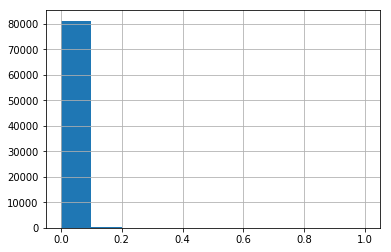

In [136]:
print(df['puncount'].describe())
df['puncount'].hist()

count    81267.000000
mean         0.032452
std          0.013096
min          0.000000
25%          0.023810
50%          0.030435
75%          0.038710
max          0.099751
Name: puncount, dtype: float64


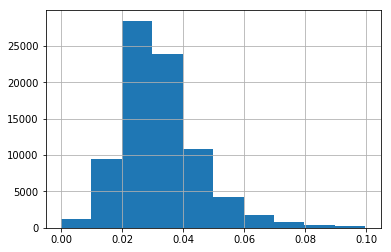

In [137]:
# drop
df = df[df['puncount'] < 0.1]
print(df['puncount'].describe())
df['puncount'].hist()

## language detect

In [138]:
from langdetect import detect

In [139]:
def detectexception(text):
    try:
        return detect(text)
    except:
        return 'NaL' # return not a language

In [140]:
# detect language (run for a while)
%time df['lan']=df['text'].apply(lambda x:detectexception(x))
#df=df.rename(index=str, columns={"lan1": "lan"})

CPU times: user 17min 28s, sys: 49.8 s, total: 18min 18s
Wall time: 17min 52s


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [141]:
# get language count
%time df.groupby(['lan'])[['text']].count()\
    .sort_values('text',ascending=False)

CPU times: user 86.5 ms, sys: 7.46 ms, total: 94 ms
Wall time: 90.6 ms


,text
lan,
en,81133
es,40
it,25
de,23
fr,20
nl,7
pt,6
et,3
ca,2


In [142]:
df_lan=df

In [143]:
# drop non-english rows
df=df[df['lan']=='en']

In [144]:
# check language count
%time df.groupby(['lan'])[['text']].count()\
    .sort_values('text',ascending=False)

CPU times: user 20.5 ms, sys: 1.71 ms, total: 22.2 ms
Wall time: 20.2 ms


,text
lan,
en,81133


In [145]:
df.to_csv('lv-pizza-en.csv')

## sentence tokenize

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


count    81133.000000
mean         7.632862
std          6.096381
min          1.000000
25%          4.000000
50%          6.000000
75%          9.000000
max         89.000000
Name: reviewsenlen, dtype: float64

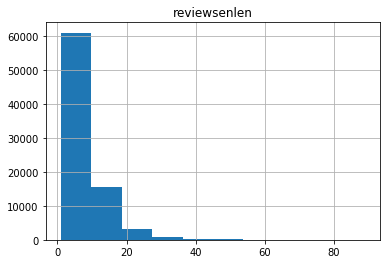

In [146]:
# get sentences of review
default_st=nltk.sent_tokenize
df['reviewsen']=df.text.apply(lambda x: default_st(text=x))
df['reviewsenlen']=df.reviewsen.apply(len)
# review sentences stat
df.hist('reviewsenlen')
df['reviewsenlen'].describe()

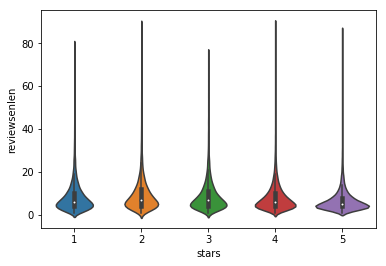

In [149]:
# if sentence lenth are related to review stars
sns.violinplot(x='stars',y='reviewsenlen',data=df)

In [150]:
# look at some longest reviews
for i in df[df['reviewsenlen']>80]['reviewsen'].head():
    pprint(i)

['I stand corrected.',
 "When I'm wrong, I'm wrong.",
 "For the record, it doesn't happen often, but when it does, I usually admit "
 'it.',
 'I have to say I was completely wrong about Buca di Beppo.',
 "I'm thankful that I'm a person of second chances.",
 "If I wasn't the person I am, I would miss out on some of the finer things "
 'this world has to offer.',
 'One of those things being, one of my new favorite Italian Spots.',
 'I decided to give this place another chance.',
 'My friend and I arrived at 5pm, just like last time.',
 'As we entered, the hostess was standing at the podium and she had the nerve '
 'to be smiling.',
 "It's been a long time since I've been anywhere where someone greeted me with "
 'a smile.',
 'Oh but she did!',
 'She was also very perky and attentive too.',
 'I like that!',
 "Make me feel like you're happy to see me lol.",
 'We were seated promptly, and once the hostess walked away, the server, Ken, '
 'came right over.',
 'He was pretty cool.',
 'He took

In [158]:
# get length of review
df.loc[:,'reviewlen']=df.loc[:,'text'].apply(len)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    81133.000000
mean       531.374435
std        493.689565
min         22.000000
25%        213.000000
50%        373.000000
75%        674.000000
max       5000.000000
Name: reviewlen, dtype: float64

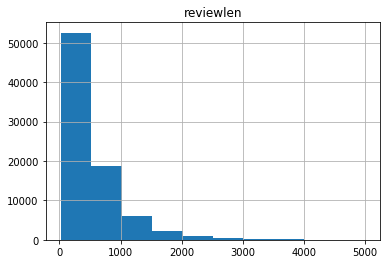

In [165]:
# review length stat
df.hist('reviewlen')
df.loc[:,'reviewlen'].describe()

## Word Tokenize

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


count    81133.000000
mean       113.668396
std        105.398106
min          4.000000
25%         46.000000
50%         80.000000
75%        144.000000
max       1128.000000
Name: reviewwordlen, dtype: float64

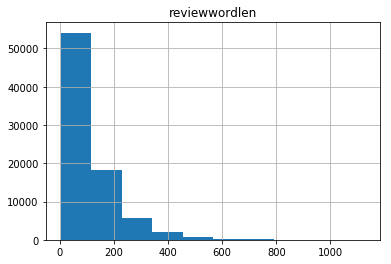

In [167]:
# get sentences of review
default_wt=nltk.word_tokenize
df['reviewword']=df.text.apply(lambda x: default_wt(text=x))
df['reviewwordlen']=df.reviewword.apply(len)
# review sentences stat
df.hist('reviewwordlen')
df['reviewwordlen'].describe()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    81133.000000
mean        15.256162
std          9.677825
min          2.666667
25%         10.666667
50%         13.736842
75%         17.470588
max        402.000000
Name: avgword, dtype: float64

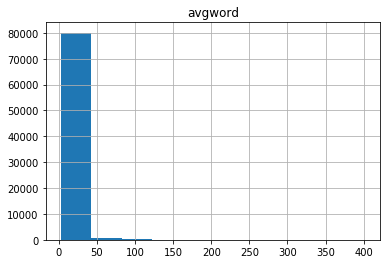

In [169]:
# people couldn't write and using comma all the time

df.loc[:,'avgword']=df.loc[:,'reviewwordlen']/df.loc[:,'reviewsenlen']
# review length stat
df.hist('avgword')
df.loc[:,'avgword'].describe()

In [172]:
sum(df['avgword']>200)

16

In [182]:
df[df['avgword']>300]

,business_id,name,biz_stars,state,city,neighborhood,address,postal_code,review_id,text,...,stars,user_id,puncount,lan,reviewsen,reviewsenlen,reviewlen,avgword,reviewword,reviewwordlen
3380,XarMlmD4QuRgGdoYoKRRSQ,Joe Philly's Pizza,3.5,NV,Las Vegas,Southeast,"6400 S Eastern Ave, Ste 25",89119,oZXNDtGMIKr7lT5iYX81jw,"First of, ive bought pizza and wings in here v...",...,1,pGhoM4pJ5p2XEH0FkVRUMw,0.015125,en,"[First of, ive bought pizza and wings in here ...",1,1719,371.0,"[First, of, ,, ive, bought, pizza, and, wings,...",371
15882,SgSVJWgMwFteYyz4OlHu9Q,Bambino's East Coast Pizzeria,4.5,NV,Las Vegas,The Lakes,2555 S Durango Dr,89117,hpEiNkMaEjdykZ5pBv0kOw,I'm just curious if I owned a pizza establishm...,...,3,dyasNvlRh290wLZ3XqKmxQ,0.005432,en,[I'm just curious if I owned a pizza establish...,1,2025,402.0,"[I, 'm, just, curious, if, I, owned, a, pizza,...",402
16609,9UZbY3FxhpNZ8sVWcYON6A,Cicis,3.0,NV,Las Vegas,Southeast,2415 E Tropicana Ave,89121,dofgMyq7K1VhmhfZhqHdUw,Let's start by telling you the worst cici's in...,...,1,kSn6_kPKbXN954Cn4lRqOg,0.008897,en,[Let's start by telling you the worst cici's i...,1,1686,344.0,"[Let, 's, start, by, telling, you, the, worst,...",344


## People tend to star higher

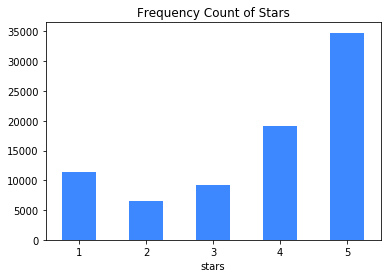

In [292]:
# star distributions
#df['stars'].hist(bins=5)
#df['stars'].value_counts().plot(kind='bar') this code doesn't sort ordinal
ax=df.groupby('stars').size().plot(kind='bar',title="Frequency Count of Stars",
                                   rot=0,color='#3d87ff')

In [184]:
# take samples to check
sample=df.sample(5)
print(sample[['reviewsenlen','reviewsen']])
for i in sample['reviewsen']:
    pprint(i)

       reviewsenlen                                          reviewsen
5240              1  [great food..spicy shrimp with egg plant and l...
8098              6  [I've been to Pizza Rock twice, and both times...
55534             5  [We had the most amazing sunset during the our...
74685             7  [I love Secret Pizza!, They keep it simple -- ...
62854            17  [Now that they're touting a gourmet menu that ...
['great food..spicy shrimp with egg plant and lamb chaps are amazing']
["I've been to Pizza Rock twice, and both times were great.",
 'Their pizzas are clearly winning awards for a reason!',
 'We got the Cal Italia (Asiago, Mozzarella, Gorgonzola, Fig, Prosciutto di '
 'Parma, Parmigiano-Reggiano, & Balsamic) the first time, and the La Regina '
 '(Sopressata Picante, Proscuitto de Parma, Mozzarella, Provola, Parmaigiano, '
 'Piave, Arugula) the second.',
 'Both pizzas were really delicious.',
 'The La Regina is big, with a delicious thick crust; we shared one pizza '


In [185]:
print('There are',len(df.business_id.unique()),'restaurants')

There are 655 restaurants


In [186]:
# check na values for each column
df.isna().sum()

business_id         0
name                0
biz_stars           0
state               0
city                0
neighborhood     6338
address            33
postal_code         0
review_id           0
text                0
date                0
cool                0
funny               0
useful              0
stars               0
user_id             0
puncount            0
lan                 0
reviewsen           0
reviewsenlen        0
reviewlen           0
avgword             0
reviewword          0
reviewwordlen       0
dtype: int64

## sentiment analysis (dr healey model)

In [188]:
# df['sentiment']=df['text'].apply(str.split).apply(sentiment.sentiment)
# df=pd.concat([df['sentiment'].apply(pd.Series),df.drop('sentiment',axis=1)],axis=1)
%time df=pd.concat([df['text'].apply(str.split).apply(sentiment.sentiment).apply(pd.Series),df],axis=1)

CPU times: user 47.8 s, sys: 1.22 s, total: 49 s
Wall time: 48.6 s


In [189]:
%time df=df.drop(df[df['valence']==0].index)

CPU times: user 190 ms, sys: 19.7 ms, total: 209 ms
Wall time: 145 ms


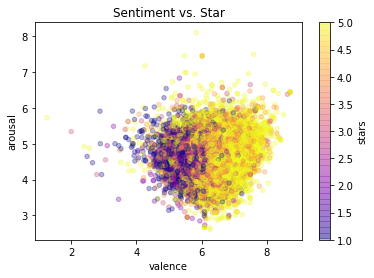

CPU times: user 3.39 s, sys: 225 ms, total: 3.62 s
Wall time: 3.46 s


In [298]:
fig, ax = plt.subplots()
df.plot.scatter(x='valence',y='arousal',c='stars',
               colormap='plasma',ax=ax, alpha=0.3,title='Sentiment vs. Star')
%time plt.show()

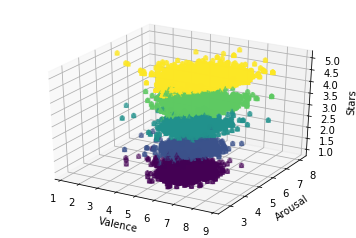

In [191]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = df['valence']
    ys = df['arousal']
    zs = df['stars']
    ax.scatter(xs, ys, zs, c=df['stars'], marker=m)

ax.set_xlabel('Valence')
ax.set_ylabel('Arousal')
ax.set_zlabel('Stars')

plt.show()

In [192]:
# how many not matching
highstarlowsent = (df.stars == 5) & (df.valence < 3)
print('total non matching:',highstarlowsent.sum())
df[highstarlowsent].text.head()

total non matching: 3


29089    Due Forni, so sad you are closed...but can't w...
49305    Food is always awesome. Great place. Wings are...
56346    Awesome pizza. Awesome suicide fries. Awesome ...
Name: text, dtype: object

In [193]:
# how many not matching
lowstarhighsent = (df.stars <2) & (df.valence > 7)
print('total non matching:',lowstarhighsent.sum())
df[lowstarhighsent].text.iloc[3]

total non matching: 39


"I Ordered The Stromboli for The first Time && it Was Cooked On The Outside w/ All Raw Dough in The Middle . The Lady Said Well its Made Of Dough Ummm Duh I Know That But it Doesn't Mean It's Suppose To Be RAW && Uncooked inside"

# Data Clean

In [195]:
stopwords = nltk.corpus.stopwords.words('english')
string.punctuation
nolem = []
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

In [196]:
def clean_text(text, join=False, stem='lemmatize'):
    # lower case and remove punctuation, here word is char so need '' to join these char back
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    
    text=re.sub(r'\d+', '', text)
    
    # break down to tokens (single word)
    tokens = re.split('\W+', text)
    
    # special words no lemmatize, and remove stop words
    # elif list comprehension: [if-1 condition_1 else_2 for_statement <condition_2>]
    
    if stem == 'lemmatize':
        if join == True:
            text = ' '.join([word if word in nolem else wn.lemmatize(word) for word in tokens if word not in stopwords ])
        else:
            text = [word if word in nolem else wn.lemmatize(word) for word in tokens if word not in stopwords ]
    elif stem == 'stem':
        if join == True:
            text = ' '.join([word if word in nolem else ps.stem(word) for word in tokens if word not in stopwords ])
        else:
            text = [word if word in nolem else ps.stem(word) for word in tokens if word not in stopwords ]
    #nostop = [word for word in tokens if word not in stopwords]
    #text = [wn.lemmatize(word) if word not in nolem else word for word in nostop]
    #text=[]
    #for word in tokens:
    #    if word in nolem:
    #        text.append(word)
    #    elif word not in stopwords:
    #        text.append(wn.lemmatize(word))
    return text

In [197]:
%time df['cleaned_text']=df['text'].apply(clean_text)

CPU times: user 59.9 s, sys: 505 ms, total: 1min
Wall time: 1min


In [198]:
df['cleaned_text'].head()

0    [displeased, pizza, came, later, scheduled, pi...
1    [ordered, pizza, location, literally, front, a...
2    [busy, place, take, good, care, right, away, w...
3    [stopped, pick, order, wing, way, home, work, ...
4    [pizza, night, child, every, week, last, two, ...
Name: cleaned_text, dtype: object

# Supervised Learning

In [56]:
from collections import defaultdict
import spacy
import gensim
import polyglot
ner_categories = defaultdict(int)

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Train test split

In [200]:
y = df['stars']

In [201]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], y,
                                                    test_size=0.3,
                                                    random_state=42)

## Count Vectorizer

In [202]:
count_vectorizer = CountVectorizer(analyzer=clean_text)
%time count_train = count_vectorizer.fit_transform(X_train)
%time count_test = count_vectorizer.transform(X_test)

CPU times: user 41 s, sys: 247 ms, total: 41.3 s
Wall time: 41.3 s
CPU times: user 17.9 s, sys: 97.1 ms, total: 18 s
Wall time: 18 s


In [203]:
print(count_vectorizer.get_feature_names()[:10])

['', 'aa', 'aaa', 'aaaaa', 'aaaaaaaand', 'aaaaaaand', 'aaaaaamazing', 'aaaaaand', 'aaaaaannnnddddbonus', 'aaaaahhhhhhhhhh']


## TFIDF Vectorizer

In [204]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(analyzer=clean_text)

# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [205]:
print(tfidf_vectorizer.get_feature_names()[:10])
print(tfidf_vectorizer.get_feature_names()[-10:])

['', 'aa', 'aaa', 'aaaaa', 'aaaaaaaand', 'aaaaaaand', 'aaaaaamazing', 'aaaaaand', 'aaaaaannnnddddbonus', 'aaaaahhhhhhhhhh']
['zummanity', 'zupas', 'zuppa', 'zza', 'zzas', 'à', 'ànd', 'éclairs', 'ît', 'ü']


## Naive Bayes

### Count Vect

In [206]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [207]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
print(metrics.accuracy_score(y_test, pred))
print('confusion matrix:\n',metrics.confusion_matrix(y_test, pred, labels=[1,2,3,4,5]))

0.6300271403898347
confusion matrix:
 [[2695  334  171  121   99]
 [ 678  346  531  308  113]
 [ 330  195  699 1234  299]
 [ 182   42  229 2854 2303]
 [ 219   26   58 1525 8727]]


### TFIDF vect

In [208]:
nb_tfidf_classifier = MultinomialNB()
nb_tfidf_classifier.fit(tfidf_train, y_train)
pred_tfidf=nb_tfidf_classifier.predict(tfidf_test)
print(metrics.accuracy_score(y_test,pred_tfidf))
print(metrics.confusion_matrix(y_test,pred_tfidf,labels=[1,2,3,4,5]))

0.5231515749650465
[[ 1920     0     1   114  1385]
 [  317     0     0   292  1367]
 [  105     0     0   479  2173]
 [   26     0     0   327  5257]
 [   23     0     0    57 10475]]


In [209]:
alphas = np.arange(0,1,0.1)

In [210]:
# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train,y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.5572004276667489

Alpha:  0.1
Score:  0.6020231926967679

Alpha:  0.2
Score:  0.593305370507443

Alpha:  0.30000000000000004


/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.5826548235874661

Alpha:  0.4
Score:  0.5715930586396908

Alpha:  0.5
Score:  0.5630397236614854

Alpha:  0.6000000000000001
Score:  0.5532527345998849

Alpha:  0.7000000000000001
Score:  0.5450283740439181

Alpha:  0.8
Score:  0.5364750390657126

Alpha:  0.9
Score:  0.5288675055514434



In [211]:
nb_classifier.classes_

array([1, 2, 3, 4, 5])

In [212]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

# Print the second class label and the bottom 20 feat_with_weights entries
print(class_labels[1], feat_with_weights[-20:])

1 [(-13.13474243966849, 'aa'), (-13.13474243966849, 'aaa'), (-13.13474243966849, 'aaaaa'), (-13.13474243966849, 'aaaaaaaand'), (-13.13474243966849, 'aaaaaaand'), (-13.13474243966849, 'aaaaaamazing'), (-13.13474243966849, 'aaaaaand'), (-13.13474243966849, 'aaaaaannnnddddbonus'), (-13.13474243966849, 'aaaaahhhhhhhhhh'), (-13.13474243966849, 'aaaaamazing'), (-13.13474243966849, 'aaaaand'), (-13.13474243966849, 'aaaahh'), (-13.13474243966849, 'aaaalcohol'), (-13.13474243966849, 'aaaammaaazzziiingggg'), (-13.13474243966849, 'aaah'), (-13.13474243966849, 'aaahhh'), (-13.13474243966849, 'aaahhhh'), (-13.13474243966849, 'aaahing'), (-13.13474243966849, 'aaallll'), (-13.13474243966849, 'aaamazing')]
2 [(-5.401934909246468, 'customer'), (-5.398435343120204, 'go'), (-5.375981895510827, 'got'), (-5.2645764931986445, 'even'), (-5.195583621711693, 'said'), (-5.1902502757363305, 'minute'), (-5.183535283195518, 'never'), (-5.141797892350383, 'u'), (-5.098169029961177, 'back'), (-5.077048244852902, 'ge

## SVM

In [213]:
from sklearn.linear_model import SGDClassifier
svm=SGDClassifier(loss='hinge',max_iter=500)

In [214]:
svm.fit(tfidf_train, y_train)
pred_svm=svm.predict(tfidf_test)
print(metrics.accuracy_score(y_test,pred_svm))
pd.DataFrame(metrics.confusion_matrix(y_test,pred_svm,labels=[1,2,3,4,5]),
            index=range(1,6),
            columns=range(1,6))

0.6272719796035858


,1,2,3,4,5
1,3100,44,55,45,176
2,1048,154,310,215,249
3,492,107,527,919,712
4,180,31,168,1455,3776
5,130,11,34,362,10018


## save scoring result to 'model_star'

In [216]:
df['model_star']=svm.predict(tfidf_vectorizer.transform(df['text']))

In [217]:
metrics.accuracy_score(df['stars'],df['model_star'])

0.6670984615764215

In [218]:
pd.DataFrame(metrics.confusion_matrix(df['stars'],df['model_star'],labels=[1,2,3,4,5]),
            index=range(1,6),
            columns=range(1,6))

,1,2,3,4,5
1,10574,128,139,126,474
2,3379,1307,604,521,766
3,1435,188,2976,2404,2176
4,492,73,365,5845,12298
5,326,29,94,967,33371


# Topic Clustering
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

In [241]:
from gensim import corpora
dictionary = corpora.Dictionary(df['cleaned_text'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_text']]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [253]:
type(corpus)

list

In [254]:
type(dictionary)

gensim.corpora.dictionary.Dictionary

In [255]:
ldamodel

In [257]:
type(topics)

list

In [258]:
lda

In [262]:
ldamodel.top_topics

<bound method LdaModel.top_topics of <gensim.models.ldamodel.LdaModel object at 0x1c7e571b38>>

In [242]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.010*"bar" + 0.009*"restaurant" + 0.009*"place" + 0.008*"table"')
(1, '0.102*"pizza" + 0.021*"slice" + 0.018*"place" + 0.017*"good"')
(2, '0.016*"good" + 0.016*"salad" + 0.015*"chicken" + 0.013*"ordered"')
(3, '0.014*"order" + 0.013*"food" + 0.013*"time" + 0.012*"u"')
(4, '0.038*"great" + 0.031*"food" + 0.027*"service" + 0.021*"place"')


In [244]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.021*"food" + 0.019*"great" + 0.015*"service" + 0.014*"good"')
(1, '0.013*"order" + 0.012*"time" + 0.011*"pizza" + 0.011*"food"')
(2, '0.064*"pizza" + 0.016*"good" + 0.015*"place" + 0.014*"slice"')


In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')

In [246]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [248]:
lda3

In [251]:
who

Axes3D	 CountVectorizer	 LogisticRegression	 MultinomialNB	 NUM_TOPICS	 SGDClassifier	 TfidfVectorizer	 X_test	 X_train	 
alpha	 alphas	 ax	 c	 class_labels	 clean_text	 corpora	 corpus	 count	 
count_test	 count_train	 count_vectorizer	 dd	 ddf	 default_st	 default_wt	 detect	 detectexception	 
df	 df_backup	 df_lan	 dictionary	 feat_with_weights	 feature_names	 fig	 gensim	 get_chunks	 
get_tfidf_weighted_keyphrases	 gutenberg	 highstarlowsent	 i	 itemgetter	 itertools	 json	 lda	 lda3	 
lda_display	 lda_display3	 ldamodel	 lib2to3	 lowstarhighsent	 m	 metrics	 models	 nb_classifier	 
nb_tfidf_classifier	 new_doc	 nltk	 nolem	 np	 pd	 pickle	 plt	 pprint	 
pred	 pred_svm	 pred_tfidf	 ps	 pyLDAvis	 re	 sample	 sentiment	 sns	 
stopwords	 string	 svm	 test	 tfidf_test	 tfidf_train	 tfidf_vectorizer	 topic	 topics	 
train_and_predict	 train_test_split	 wn	 xs	 y	 y_test	 y_train	 ys	 zhigh	 
zlow	 zs	 


In [247]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [265]:
CorpusTermFrequency = np.array([[(dictionary[id], freq) for id, freq in cp] for cp in corpus])

In [268]:
len(CorpusTermFrequency)

81057

In [300]:
testt=[[(dictionary[id], freq) for id, freq in cp] for cp in corpus]

In [301]:
len(testt)

81057

In [ ]:
consolidate

In [302]:
test1=[cp for cp in corpus]

In [307]:
from collections import defaultdict
# list1 = [('a', 0), ('b', 0), ('c', 0)]
# list2 = [('a', 5), ('c', 3)]
d = defaultdict(list)
for cp in corpus:
   d=d.append(cp)

#final_data = sorted([(a, max(b)) for a, b in d.items()], key=lambda x:x[0])

AttributeError: 'collections.defaultdict' object has no attribute 'append'

In [312]:
from collections import defaultdict
list1 = [('a', 10), ('b', 0), ('c', 0)]
list2 = [('a', 53), ('c', 3)]
d = defaultdict(list)
for a, b in list1+list2:
   d[a].append(b)

In [332]:
# corpus = [dictionary.doc2bow(sent) for sent in documents]
vocab_tf={}
for i in corpus:
    for item,count in dict(i).items():
        item = dictionary[item]
        if item in vocab_tf:
            vocab_tf[item]+=count
        else:
            vocab_tf[item] = count

In [333]:
len(vocab_tf)

62640

In [317]:
key, value = vocab_tf.popitem()

In [389]:
 vocab_tf.popitem()

('languishing', 1)

In [ ]:
import multidict as multidict

import numpy as np

import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# def getFrequencyDictForText(sentence):
#     fullTermsDict = multidict.MultiDict()
#     tmpDict = {}

#     # making dict for counting frequencies
#     for text in sentence.split(" "):
#         if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be", text):
#             continue
#         val = tmpDict.get(text, 0)
#         tmpDict[text.lower()] = val + 1
#     for key in tmpDict:
#         fullTermsDict.add(key, tmpDict[key])
#     return fullTermsDict


def makeImage(text):
    yelp_mask = np.array(Image.open("Yelp.png"))

    wc = WordCloud(background_color="white", max_words=1000, mask=yelp_mask)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()


# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

text = open(path.join(d, 'alice.txt'), encoding='utf-8')
text = text.read()
makeImage(getFrequencyDictForText(text))